# Samsung Multivarite Stock Forecasat with LSTM

# Install Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Load the Data

In [ ]:
df = pd.read_csv("/content/Samsung Dataset.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.709961,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.859863,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.098145,46880000


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6122,2024-06-07,78400.0,78600.0,77100.0,77300.0,77300.0,21189349
6123,2024-06-10,76100.0,76600.0,75600.0,75700.0,75700.0,14598755
6124,2024-06-11,75900.0,76000.0,75100.0,75200.0,75200.0,16971175
6125,2024-06-12,75300.0,77100.0,75200.0,76500.0,76500.0,19246725
6126,2024-06-13,78400.0,79000.0,77800.0,78600.0,78600.0,33763804


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6127 non-null   object 
 1   Open       6127 non-null   float64
 2   High       6127 non-null   float64
 3   Low        6127 non-null   float64
 4   Close      6127 non-null   float64
 5   Adj Close  6127 non-null   float64
 6   Volume     6127 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 335.2+ KB


In [ ]:
# Create a date range for filtering
start_date = '2023-06-01'
end_date = '2024-06-13'

# Convert 'date' column to datetime if it isn't already
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
print(filtered_df)


           Date     Open     High      Low    Close     Adj Close    Volume
5874 2023-06-01  70900.0  71600.0  70600.0  70900.0  69534.218750  14669296
5875 2023-06-02  71700.0  72200.0  71600.0  72200.0  70809.179688  12161798
5876 2023-06-05  72700.0  72700.0  71400.0  71700.0  70318.812500  12686829
5877 2023-06-07  71300.0  71600.0  70800.0  71000.0  69632.304688  14796613
5878 2023-06-08  70400.0  70900.0  70000.0  70900.0  69534.218750  19165568
...         ...      ...      ...      ...      ...           ...       ...
6122 2024-06-07  78400.0  78600.0  77100.0  77300.0  77300.000000  21189349
6123 2024-06-10  76100.0  76600.0  75600.0  75700.0  75700.000000  14598755
6124 2024-06-11  75900.0  76000.0  75100.0  75200.0  75200.000000  16971175
6125 2024-06-12  75300.0  77100.0  75200.0  76500.0  76500.000000  19246725
6126 2024-06-13  78400.0  79000.0  77800.0  78600.0  78600.000000  33763804

[253 rows x 7 columns]


In [ ]:
df = filtered_df.copy()

In [ ]:
# Preprocessing data (multivariate features)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Open', 'High', 'Low', 'Volume', 'Close']].values

# Preprocess the Data

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [ ]:
# Define lookback window and features
timesteps = 10
num_features = scaled_data.shape[1]

In [ ]:
# Prepare training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [ ]:
# Create dataset matrix for LSTM (multivariate)
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, :])  # Use all features, not just the first one
        y.append(dataset[i + look_back, -1])  # Predict 'Close' price
    return np.array(X), np.array(y)

In [ ]:
look_back = timesteps
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [ ]:
# Reshape input to [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# LSTM Model

In [ ]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model

In [ ]:
# Fit the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051 - val_loss: 0.0107
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - val_loss: 0.0085
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0138
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - val_loss: 0.0082
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0097
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - val_loss: 0.0067
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0115
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - val_loss: 0.0059
E

In [ ]:
# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━

# Prediction

In [ ]:
# Predictions
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
# Inverse scaling to get the original 'Close' price
# We only need the 'Close' column to be inverse scaled

# Extract the 'Close' price from the test data and predictions
scaled_close = test_data[timesteps:, -1].reshape(-1, 1)
y_test_close = np.zeros((len(scaled_close), num_features))
y_test_close[:, -1] = scaled_close.flatten()

# Inverse transform the real test data
y_test_original = scaler.inverse_transform(y_test_close)[:, -1]

# Predicting values
y_pred_close = np.zeros((len(y_pred), num_features))
y_pred_close[:, -1] = y_pred.flatten()

# Inverse transform the predicted values
y_pred_original = scaler.inverse_transform(y_pred_close)[:, -1]


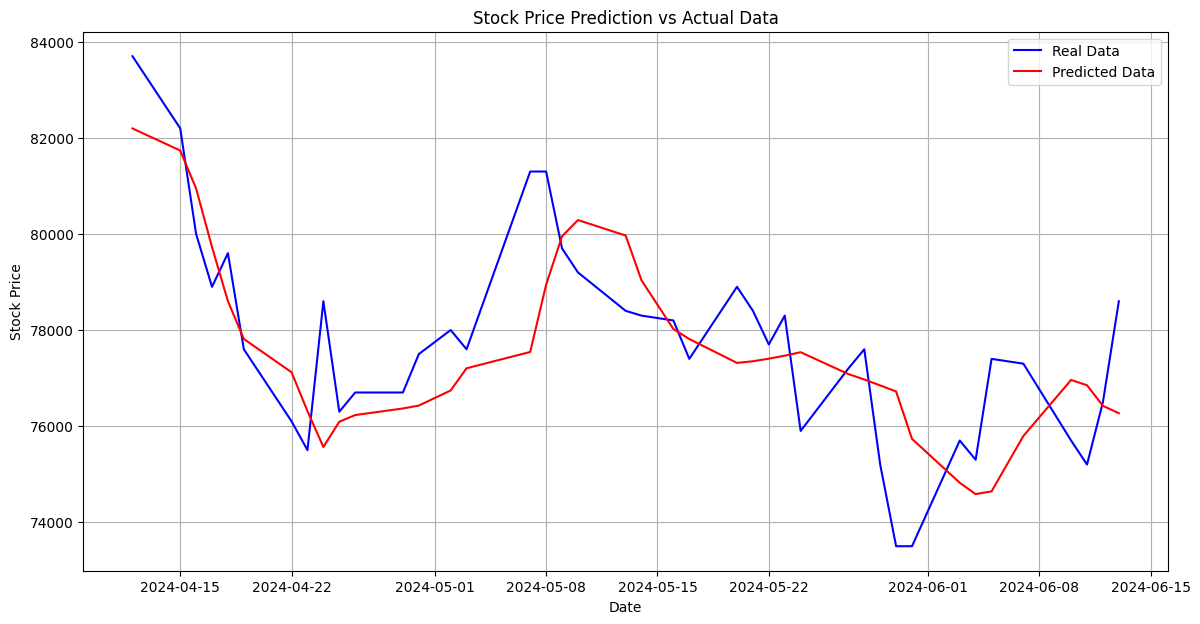

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='blue')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()



# Next 30 Days Forecast

In [ ]:
# Number of days to forecast
forecast_days = 30

# Prepare input data for forecasting
last_known_data = test_data[-look_back:]  # Last known data from the test set

# Prepare arrays to store forecast results
forecast_data = np.zeros((forecast_days, num_features))

# Perform forecasting
for i in range(forecast_days):
    # Predict next step
    next_step = model.predict(last_known_data.reshape(1, look_back, num_features))

    # Save the prediction
    forecast_data[i, -1] = next_step.flatten()

    # Update the input data for the next step
    last_known_data = np.roll(last_known_data, -1, axis=0)
    last_known_data[-1, -1] = next_step.flatten()

# Inverse transform the forecast data
forecast_data_original = scaler.inverse_transform(forecast_data)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<ipython-input-31-8373385fc4d5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_data[i, -1] = next_step.flatten()
<ipython-input-31-8373385fc4d5>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_data[-1, -1] = next_step.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


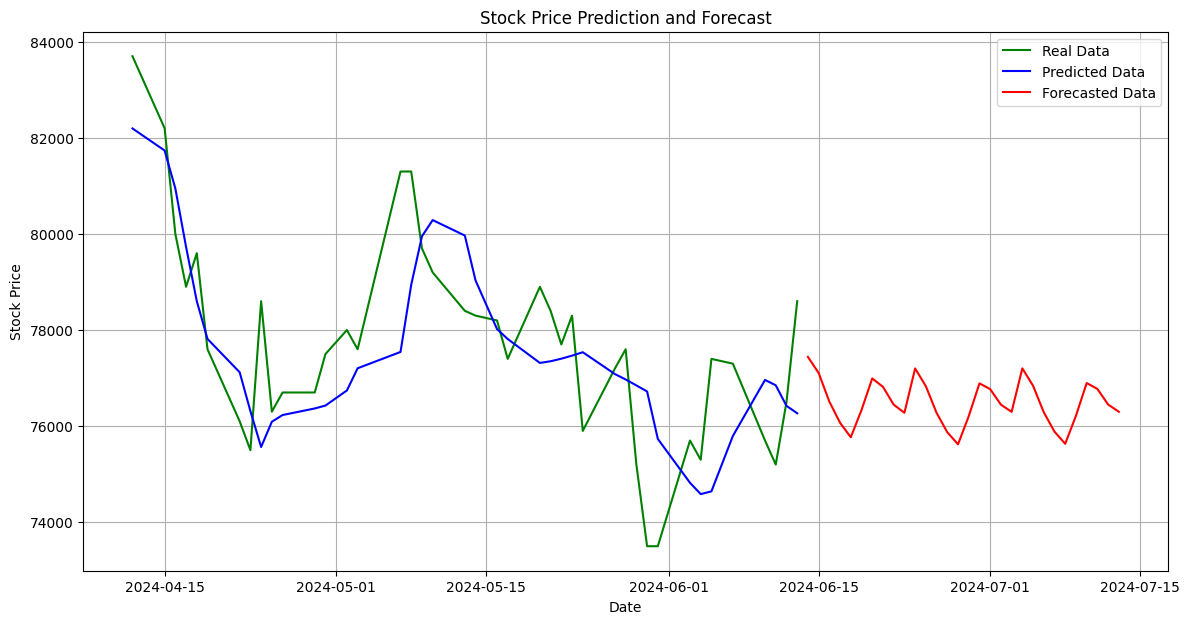

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


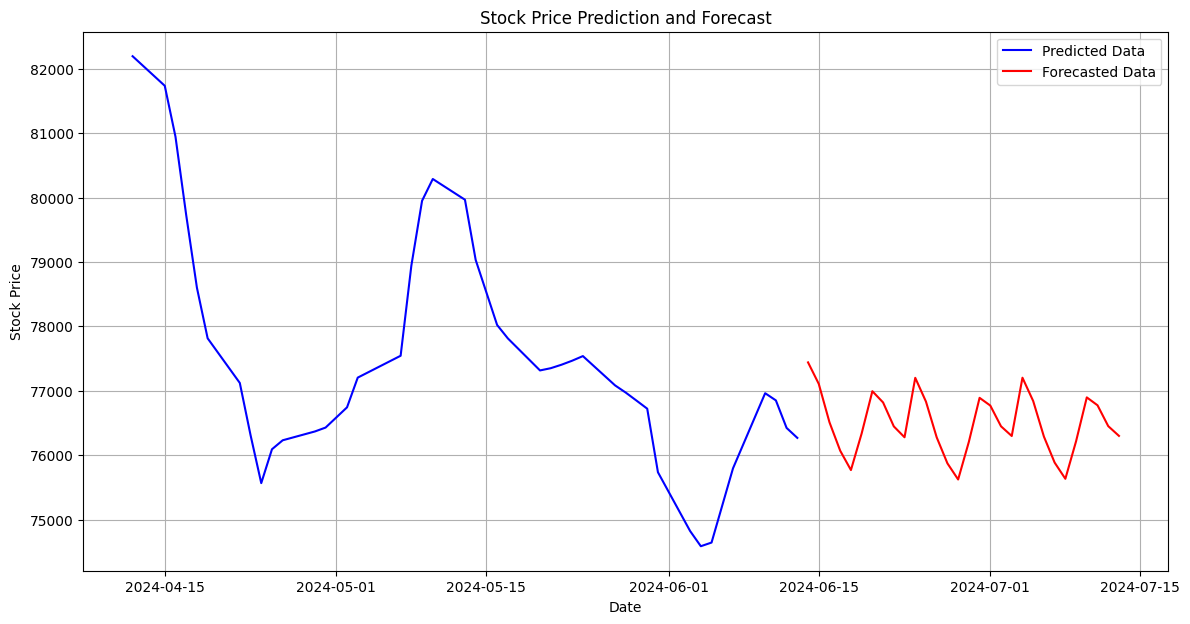

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot
plt.figure(figsize=(14,7))


# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


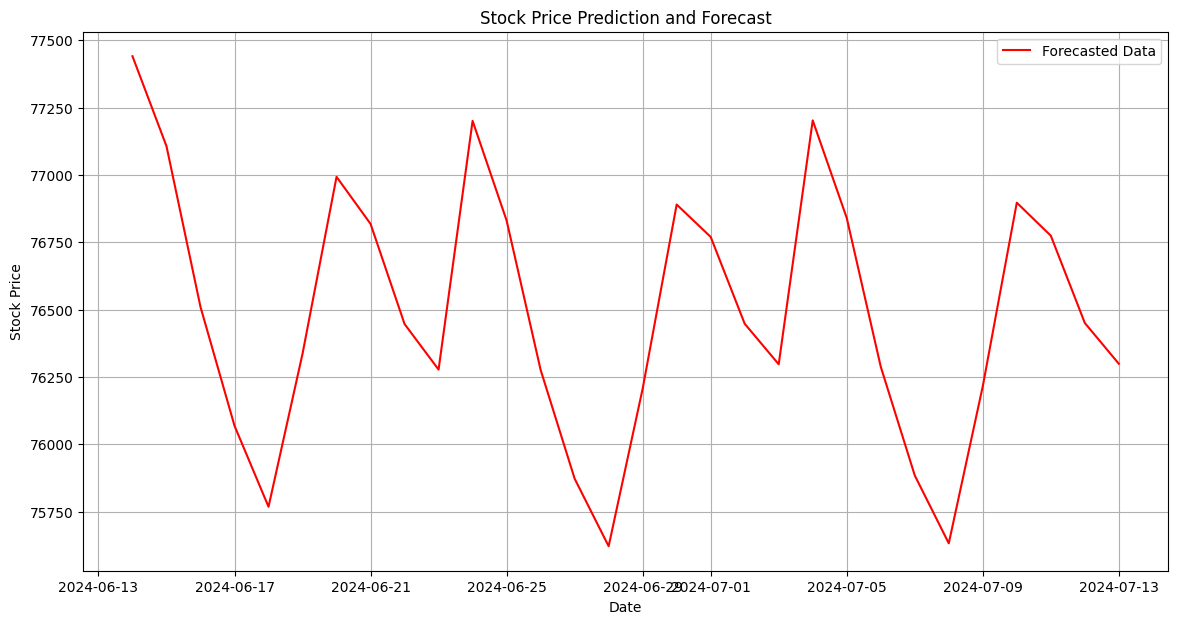

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the
plt.figure(figsize=(14,7))


# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


# Next 90 Days Forecast

In [ ]:
# Number of days to forecast
forecast_days = 90

# Prepare input data for forecasting
last_known_data = test_data[-look_back:]  # Last known data from the test set

# Prepare arrays to store forecast results
forecast_data = np.zeros((forecast_days, num_features))

# Perform forecasting
for i in range(forecast_days):
    # Predict next step
    next_step = model.predict(last_known_data.reshape(1, look_back, num_features))

    # Save the prediction
    forecast_data[i, -1] = next_step.flatten()

    # Update the input data for the next step
    last_known_data = np.roll(last_known_data, -1, axis=0)
    last_known_data[-1, -1] = next_step.flatten()

# Inverse transform the forecast data
forecast_data_original = scaler.inverse_transform(forecast_data)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-35-d52c3b6182da>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_data[i, -1] = next_step.flatten()
<ipython-input-35-d52c3b6182da>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_data[-1, -1] = next_step.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

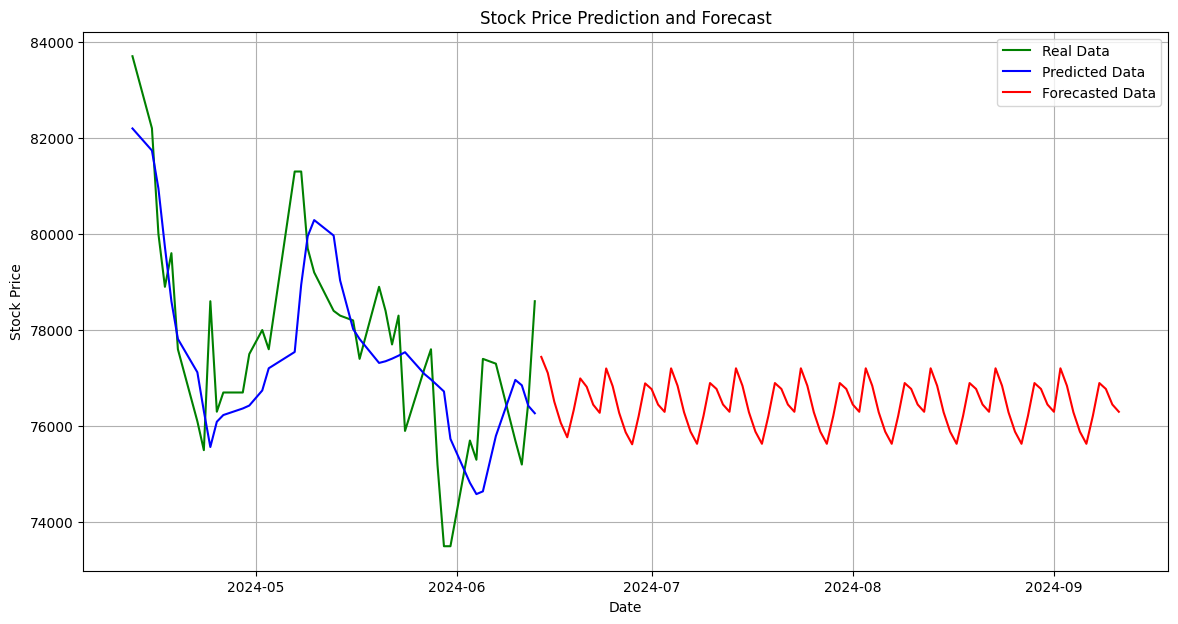

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


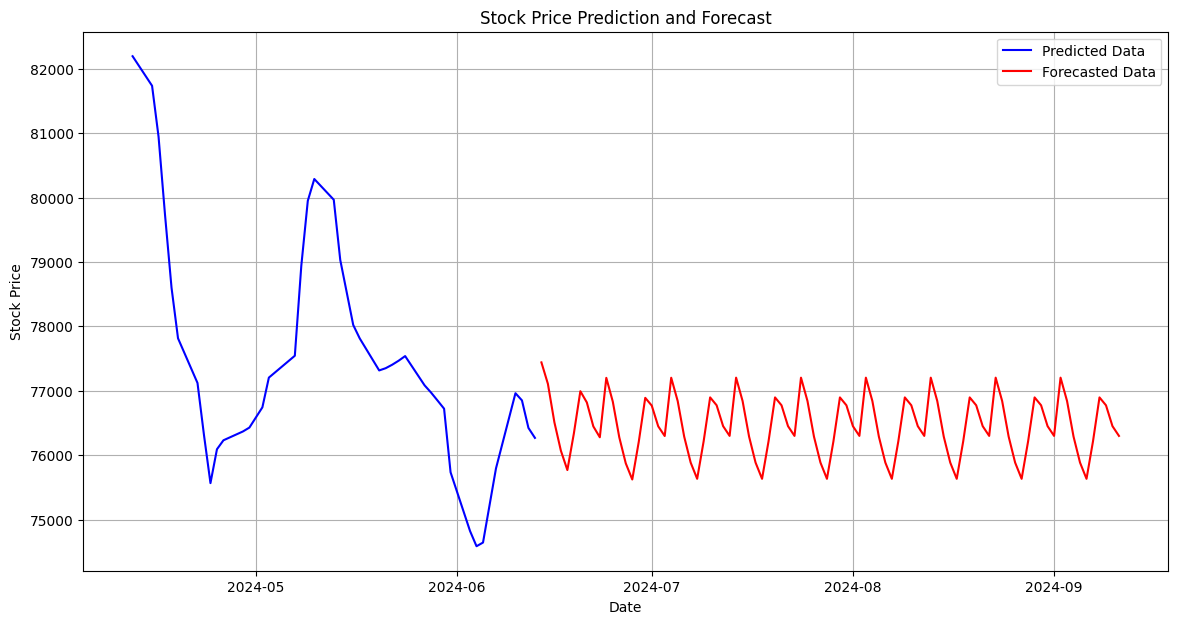

In [ ]:
plt.figure(figsize=(14,7))

# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


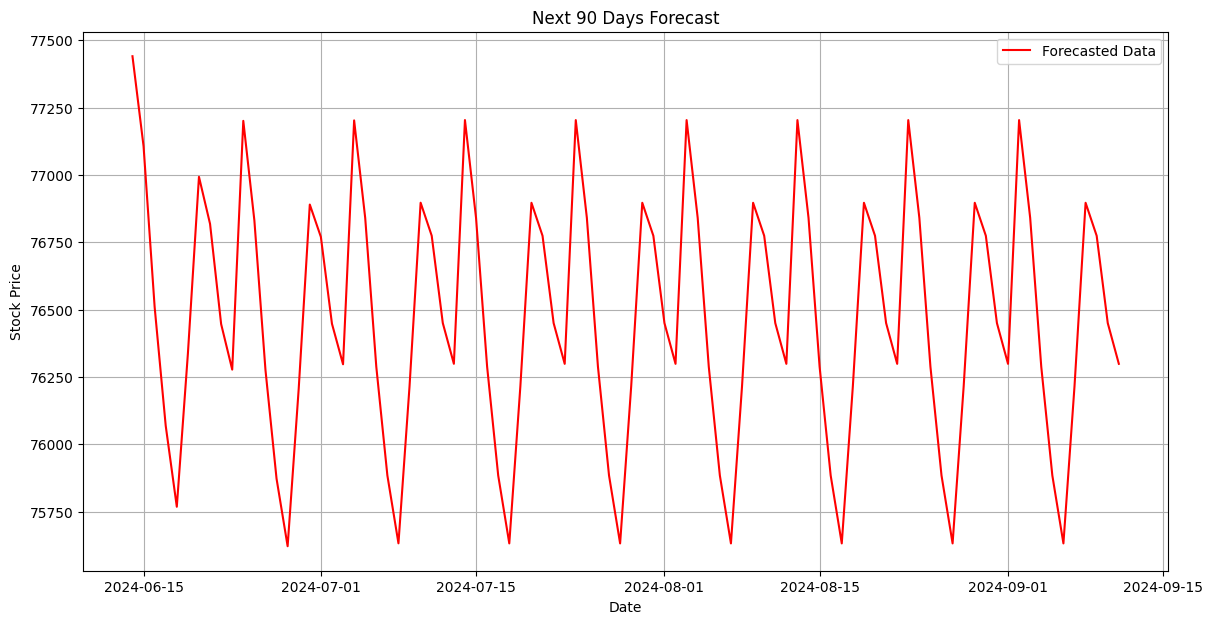

In [ ]:
plt.figure(figsize=(14,7))

# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)


# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Next 90 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()
